# Experiment 1 - Network Convergence

### Summary

In this experiment, the objective is to understand if the backpropagation throught time algorithm converges in this network using different input signals

In [19]:
# imports
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from ssnn import SSNN
import os
from tqdm.notebook import tqdm
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,1), 'MB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**2,1), 'MB')


NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 2.3 MB
Cached:    4.0 MB


In [20]:
# for reproductibility
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True
torch.use_deterministic_algorithms(True)

%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [21]:
# support functions

def observability(A:torch.Tensor, C:torch.Tensor):
    """
    Returns observability matrix
    """
    with torch.no_grad():
        O = torch.zeros(A.shape[0], C.shape[1])
        for row in range(len(O)):
            O[row] = torch.matmul(C, torch.linalg.matrix_power(A, row))
    return O

def clamp(n, minn, maxn):
    """
    Clamps number between 2
    """
    return max(min(maxn, n), minn)

def save_gif(title:str, dir:str, **kwargs):
    """
    create a gif vizualization of this training process
    """
    
    plot_size = kwargs["plot_size"]
    signal_amplitude = kwargs["signal_amplitude"]
    n_epochs = kwargs["n_epochs"]
    t_loss = kwargs["t_loss"]
    t_plot = kwargs["t_plot"]
    t_observability = kwargs["t_observability"]

    fig, (ax1, ax2) = plt.subplots(2,1)

    ax1.set_title("Output over time")
    ax2.set_title("Loss over epoch")

    line1, = ax1.plot([])
    line2, = ax2.plot([])

    ax1.set_xlim(0, plot_size)
    ax1.set_ylim(-signal_amplitude-5, signal_amplitude+5)

    ax2.set_xlim(0, n_epochs)
    ax2.set_ylim(t_loss[0]-0.5, t_loss[0]+0.5)

    ax1.set_xticks([])

    t_text1 = ax1.text(.5, -signal_amplitude-5+0.5, '', fontsize=10)
    t_text2 = ax2.annotate("", xy = (10, -30), size=10, color='k', xycoords='axes points')
    t_text3 = ax2.annotate("", xy = (80, -30), size=10, color='k', xycoords='axes points')

    def animate(frame_n):
        x1 = np.arange(0, plot_size, 1)
        y1 = t_plot[frame_n].cpu().detach().numpy()

        x2 = np.arange(0, frame_n, 1)
        y2 = np.array(t_loss)[0:frame_n]

        line1.set_data((x1, y1))
        line1.set_color('b')
        line2.set_data((x2, y2))
        line2.set_color('k')

        t_text1.set_text(f"epoch:{frame_n}")
        t_text2.set_text(f"loss:{t_loss[frame_n]:.2f}")
        t_text3.set_text(f"det(O):{t_observability[frame_n]:.2e}")
        
        t_text3.set_text(f"det(O):{t_observability[frame_n]:.2e}")

        if frame_n != 0:
            ax2.set_ylim(   clamp(min(np.array(t_loss)[:frame_n]), 0, 1000)-0.5,
                            clamp(max(np.array(t_loss)[:frame_n]), 0, 1000)+0.5)

        return line1, line2

    anim = FuncAnimation(fig, animate, frames=n_epochs, interval=1)
    anim.save(os.path.join(os.getcwd(), dir, title), writer = 'pillow')
    plt.close()

## Experiment with pure sine

### Some notes regarding data generation and processing

In the signal generation, there are some things that need to be considered. Those are:
- Total number of samples
- Sampling rate of signal
- Amplitude and frequency parameters
- Windowing length

Total *number of samples* is arbitrary, provided that it has enough information on the signal. *Sampling rate* must follows the *Nyquist-theorem* of greater than 2 times the maximum frequency of signal. We choose $FS = 10\times \max{f}$. The window lenght is also chosen according to the *Nyquist-theorem*: we choose it to be 5*(1/$f_{max}$)*SR

torch.Size([900, 100, 1])
torch.Size([900, 1])
torch.Size([1, 30, 1])


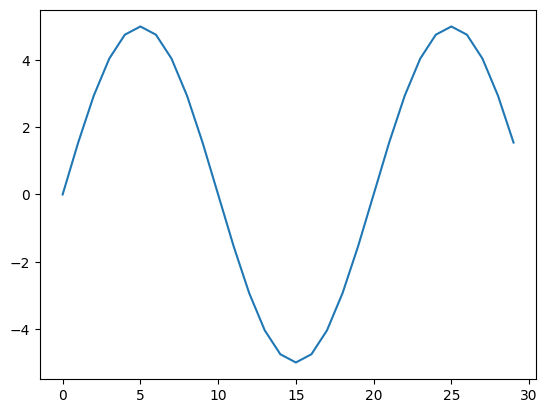

In [4]:
# Generate signal, windows it, generate input and output data.
train_len = 1000
eval_len = 30
sampling_rate = 20
window_len = 100

A1 = 5
w1 = 2*math.pi*1

plot_size = 100

def generate_data(train_len:int, sampling_rate:int, window_len:int, decimation:int=1, **kwargs):
    A1 = kwargs['A1']
    w1 = kwargs['w1']

    eval_len = kwargs['eval_len']

    # generate a sine dataset
    x_train = torch.arange(0, train_len/sampling_rate, 1/sampling_rate)

    x_train = x_train.unfold(0, window_len+1, decimation)
    x_train = x_train.unsqueeze(-1)

    y_train = x_train[:,-1,:]
    x_train = x_train[:,0:-1,:]

    x_train = A1*torch.sin(w1*x_train)
    y_train = A1*torch.sin(w1*y_train)

    x_eval = torch.arange(train_len/sampling_rate, (train_len+eval_len)/sampling_rate, 1/sampling_rate)
    x_eval = x_eval.unsqueeze(-1)
    x_eval = x_eval.unsqueeze(0)
    eval_signal = A1*torch.sin(w1*x_eval)

    return (x_train, y_train), eval_signal

(train_signal, train_target), eval_signal = generate_data(
                    train_len,
                    sampling_rate,
                    window_len,
                    A1=A1, w1=w1, eval_len=eval_len)

train_signal = train_signal.to(device)
train_target = train_target.to(device)
eval_signal = eval_signal.to(device)

print(train_signal.shape)
print(train_target.shape)
print(eval_signal.shape)

plt.plot(eval_signal.squeeze(0).cpu())

In [5]:
# load ssnn model
model = SSNN(u_len = 1, x_len = 10, y_len = 1)
model = model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [6]:
# train loop
t_loss = []
t_plot = []
t_observability = []

n_epochs = 100
batch_size = 32

for epoch in tqdm(range(n_epochs)):
    batch = 0
    while batch < int(train_signal.shape[0]/batch_size):
        optimizer.zero_grad()
        outputs = model(train_signal[batch*batch_size:(batch+1)*batch_size])
        outputs = outputs[:, -1, :]
        loss = criterion(outputs, train_target[batch*batch_size:(batch+1)*batch_size])
        
        t_loss.append(loss.item())
        with torch.no_grad():
            t_observability.append(torch.linalg.det(observability(model.A, model.C)).item())

        loss.backward()
        optimizer.step()

        batch += 1

    # last batch
    optimizer.zero_grad()
    outputs = model(train_signal[batch*batch_size:-1])
    outputs = outputs[:, -1, :]
    loss = criterion(outputs, train_target[batch*batch_size:-1])

    t_loss.append(loss.item())
    with torch.no_grad():
        t_observability.append(torch.linalg.det(observability(model.A, model.C)).item())

    loss.backward()
    optimizer.step()

    # eval per epoch
    y_eval = eval_signal

    for t in range(plot_size-eval_len):
        with torch.no_grad():
            y_eval = torch.cat((y_eval, model(y_eval[:, t:eval_len+t, :])[:,-1,:].unsqueeze(-1)), dim=1)
    t_plot.append(y_eval.squeeze())

save_gif("pure-sine.gif", "./results/experiment-1", plot_size=plot_size, signal_amplitude=A1, n_epochs=n_epochs, t_loss=t_loss, t_plot=t_plot, t_observability=t_observability)

  0%|          | 0/100 [00:00<?, ?it/s]

## 3 sine harmonics

### Notes regarding signal generation

Things discussed in the last note also applies here. This time, we generate the signal using the first 3 components of the square-wave fourier series.

torch.Size([500, 500, 1])
torch.Size([500, 1])
torch.Size([1, 100, 1])


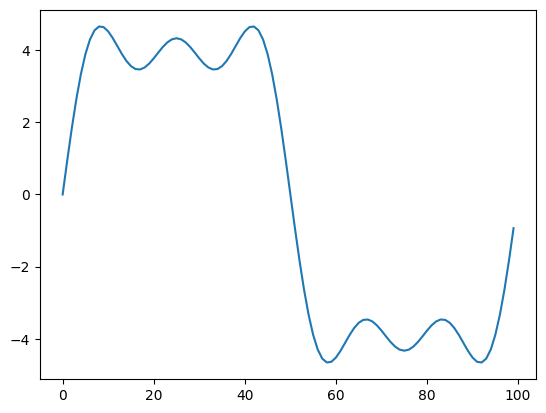

In [22]:
# Generate signal, windows it, generate input and output data.
train_len = 1000
eval_len = 100
sampling_rate = 20
window_len = 500

A1 = 5/1
A2 = 5/3
A3 = 5/5

w1 = 2*math.pi*1/5
w2 = 2*math.pi*3/5
w3 = 2*math.pi*5/5

plot_size = 1000

def generate_data(train_len:int, sampling_rate:int, window_len:int, decimation:int=1, **kwargs):
    A1 = kwargs['A1']
    A2 = kwargs['A2']
    A3 = kwargs['A3']
    w1 = kwargs['w1']
    w2 = kwargs['w2']
    w3 = kwargs['w3']

    eval_len = kwargs['eval_len']

    # generate a sine dataset
    x_train = torch.arange(0, train_len/sampling_rate, 1/sampling_rate)

    x_train = x_train.unfold(0, window_len+1, decimation)
    x_train = x_train.unsqueeze(-1)

    y_train = x_train[:,-1,:]
    x_train = x_train[:,0:-1,:]

    x_train = A1*torch.sin(w1*x_train)+A2*torch.sin(w2*x_train)+A3*torch.sin(w3*x_train)
    y_train = A1*torch.sin(w1*y_train)+A2*torch.sin(w2*y_train)+A3*torch.sin(w3*y_train)

    x_eval = torch.arange(train_len/sampling_rate, (train_len+eval_len)/sampling_rate, 1/sampling_rate)
    x_eval = x_eval.unsqueeze(-1)
    x_eval = x_eval.unsqueeze(0)
    eval_signal = A1*torch.sin(w1*x_eval)+A2*torch.sin(w2*x_eval)+A3*torch.sin(w3*x_eval)

    return (x_train, y_train), eval_signal

(train_signal, train_target), eval_signal = generate_data(
                    train_len,
                    sampling_rate,
                    window_len,
                    A1=A1, w1=w1, A2=A2, w2=w2, A3=A3, w3=w3, eval_len=eval_len)

train_signal = train_signal.to(device)
train_target = train_target.to(device)
eval_signal = eval_signal.to(device)

print(train_signal.shape)
print(train_target.shape)
print(eval_signal.shape)

plt.plot(eval_signal.squeeze(0).cpu())

In [23]:
# load ssnn model
model = SSNN(u_len = 1, x_len = 10, y_len = 1)
model = model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [25]:
# train loop
t_loss = []
t_plot = []
t_observability = []

n_epochs = 500
batch_size = 32

for epoch in tqdm(range(n_epochs)):
    batch = 0
    while batch < int(train_signal.shape[0]/batch_size):
        optimizer.zero_grad()
        outputs = model(train_signal[batch*batch_size:(batch+1)*batch_size])
        outputs = outputs[:, -1, :]
        loss = criterion(outputs, train_target[batch*batch_size:(batch+1)*batch_size])
        
        t_loss.append(loss.item())
        with torch.no_grad():
            t_observability.append(torch.linalg.det(observability(model.A, model.C)).item())

        loss.backward()
        optimizer.step()
# - Loss: MSE
# - SGD without momentum

        batch += 1

    # last batch
    optimizer.zero_grad()
    outputs = model(train_signal[batch*batch_size:-1])
    outputs = outputs[:, -1, :]
    loss = criterion(outputs, train_target[batch*batch_size:-1])

    t_loss.append(loss.item())
    with torch.no_grad():
        t_observability.append(torch.linalg.det(observability(model.A, model.C)).item())

    loss.backward()
    optimizer.step()

    # eval per epoch
    y_eval = eval_signal

    for t in range(plot_size-eval_len):
        with torch.no_grad():
            y_eval = torch.cat((y_eval, model(y_eval[:, t:eval_len+t, :])[:,-1,:].unsqueeze(-1)), dim=1)
    t_plot.append(y_eval.squeeze())

save_gif("3-harmonics.gif", "./results/experiment-1", plot_size=plot_size, signal_amplitude=A1, n_epochs=n_epochs, t_loss=t_loss, t_plot=t_plot, t_observability=t_observability)

  0%|          | 0/500 [00:00<?, ?it/s]